In [1]:
import requests
import pandas as pd
import numpy as np
import geopandas as gpd
from geopandas import GeoDataFrame
import requests
import json
from bs4 import BeautifulSoup as BS
from IPython.core.display import HTML
import re
import time 
from tqdm.notebook import tqdm



from io import StringIO
import statsmodels.api as sm
from statsmodels.formula.api import glm

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

### 4. Using your scraped data, investigates different relationships between candidates and the amount of money they raised. Here are some suggestions to get you started, but feel free to pose you own questions or do additional exploration:

#### a. How often does the candidate who raised more money win a race?


In [2]:
states_df= pd.read_csv('../data/states_df.csv')
states_df
#states_df.info()

,candidate,raised,spent,cash_left,year,state,district,party,incumbent,winner
0,Jerry Carl,1971321.0,1859349.0,111973.0,2020-12-31,AL,1,R,NaN,Winner
1,James Averhart,80095.0,78973.0,1122.0,2020-12-31,AL,1,D,NaN,NaN
2,Barry Moore,650807.0,669368.0,-13633.0,2020-12-31,AL,2,R,NaN,Winner
3,Phyllis Harvey,56050.0,55988.0,0.0,2020-12-31,AL,2,D,NaN,NaN
4,Mike D Rogers,1193111.0,1218564.0,502234.0,2020-12-31,AL,3,R,Incumbent,Winner
...,...,...,...,...,...,...,...,...,...,...
889,Tricia Zunker,1261957.0,1232690.0,29267.0,2020-12-31,WI,7,D,NaN,NaN
890,Mike Gallagher,3202905.0,2841801.0,1169362.0,2020-12-31,WI,8,R,Incumbent,Winner
891,Amanda Stuck,416978.0,399916.0,2165.0,2020-12-31,WI,8,D,NaN,NaN
892,Liz Cheney,3003883.0,3060167.0,153567.0,2020-12-31,WY,1,R,Incumbent,Winner


In [3]:
states_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   candidate  884 non-null    object 
 1   raised     894 non-null    float64
 2   spent      894 non-null    float64
 3   cash_left  894 non-null    float64
 4   year       894 non-null    object 
 5   state      894 non-null    object 
 6   district   894 non-null    int64  
 7   party      894 non-null    object 
 8   incumbent  386 non-null    object 
 9   winner     431 non-null    object 
dtypes: float64(3), int64(1), object(6)
memory usage: 70.0+ KB


In [4]:
states_df['incumbent']=states_df['incumbent'].fillna(0)

In [5]:
states_df['winner']=states_df['winner'].fillna(0)

In [6]:
states_df['incumbent'] = states_df['incumbent'].replace({'Incumbent': 1})

In [7]:
states_df['winner'] = states_df['winner'].replace({'Winner': 1})

In [8]:
states_df

,candidate,raised,spent,cash_left,year,state,district,party,incumbent,winner
0,Jerry Carl,1971321.0,1859349.0,111973.0,2020-12-31,AL,1,R,0,1
1,James Averhart,80095.0,78973.0,1122.0,2020-12-31,AL,1,D,0,0
2,Barry Moore,650807.0,669368.0,-13633.0,2020-12-31,AL,2,R,0,1
3,Phyllis Harvey,56050.0,55988.0,0.0,2020-12-31,AL,2,D,0,0
4,Mike D Rogers,1193111.0,1218564.0,502234.0,2020-12-31,AL,3,R,1,1
...,...,...,...,...,...,...,...,...,...,...
889,Tricia Zunker,1261957.0,1232690.0,29267.0,2020-12-31,WI,7,D,0,0
890,Mike Gallagher,3202905.0,2841801.0,1169362.0,2020-12-31,WI,8,R,1,1
891,Amanda Stuck,416978.0,399916.0,2165.0,2020-12-31,WI,8,D,0,0
892,Liz Cheney,3003883.0,3060167.0,153567.0,2020-12-31,WY,1,R,1,1


In [9]:
#Number of times D vs. R has won the elections.
party_winners=states_df.groupby('winner')['party'].value_counts()
party_winners

winner  party
0       D        203
        R        178
        I         46
        L         21
        3         15
1       D        221
        R        210
Name: party, dtype: int64

In [10]:
states_df.nlargest (20, 'raised')

,candidate,raised,spent,cash_left,year,state,district,party,incumbent,winner
354,Steve Scalise,37262827.0,32830607.0,6217720.0,2020-12-31,LA,1,R,1,1
80,Kevin McCarthy,27780644.0,24265583.0,4802133.0,2020-12-31,CA,23,R,1,1
60,Nancy Pelosi,27359508.0,22064953.0,6299373.0,2020-12-31,CA,12,D,1,1
78,Devin Nunes,26825212.0,20156093.0,10908033.0,2020-12-31,CA,22,R,1,1
547,Alexandria Ocasio,20664795.0,16735422.0,4297383.0,2020-12-31,NY,14,D,1,1
732,Dan Crenshaw,19427865.0,17596329.0,1852715.0,2020-12-31,TX,2,R,1,1
90,Adam Schiff,19382855.0,10188664.0,13908271.0,2020-12-31,CA,28,D,1,1
611,Jim Jordan,18313823.0,12945651.0,6113812.0,2020-12-31,OH,4,R,1,1
121,Katie Porter,16627706.0,6443700.0,10267752.0,2020-12-31,CA,45,D,1,1
561,Elise Stefanik,13287248.0,11655936.0,1983541.0,2020-12-31,NY,21,R,1,1


In [11]:
states_df.nsmallest (20, 'raised')

,candidate,raised,spent,cash_left,year,state,district,party,incumbent,winner
645,Mary Brannon,-2084.0,1599.0,1734.0,2020-12-30,OK,4,D,0,0
194,Kristofer Steven Lawson,47.0,47.0,0.0,2020-06-30,FL,10,I,0,0
762,Michael David Sanchez,100.0,12.0,88.0,2020-09-30,TX,14,I,0,0
531,Amit Lal,126.0,0.0,126.0,2020-11-16,NY,5,I,0,0
526,Joshua Sauberman,127.0,270.0,-2258.0,2020-12-31,NY,3,I,0,0
649,Chris Christensen,144.0,672.0,0.0,2020-11-20,OR,1,R,0,0
175,Kristy Thripp,145.0,145.0,0.0,2020-09-30,FL,2,I,0,0
709,Larry Guy Hammond,199.0,199.0,0.0,2020-10-03,SC,7,L,0,0
444,Ervan Katari Miller,255.0,187.0,68.0,2019-09-16,MN,5,I,0,0
477,Mark Elworth Jr,255.0,0.0,255.0,2020-06-30,NE,3,D,0,0


In [12]:
all_states = pd.DataFrame()

def get_all_reps_time(df, st_col, rep_col, year):
    """Takes in a DataFrame that holds the number of representatives per state and the year to
    pull data for from opersecrets.org and returns a dataframe of nationwide candidates and
    associated info.
    
    df: Variable name for the DataFrame that holds the state and number of Reps
    st_col: the DataFrame column that holds the two-digit state code
    rep_col: the DataFrame column that holds the number of reps
    year: Needs to be a string and 4 digits.
    """
    
    # Defining the function that will set up the columns in the final dataframe
    def fix_columns(df):
        df['party'] = df['Candidate'].str.extract(r'\((\w)\)')
        df['incumbent'] = df['Candidate'].str.extract(r'([I]\w+)')
        df['winner'] = df['Candidate'].str.extract(r'([W]\w+)')
        df['candidate'] = df['Candidate'].str.extract(r'(^\w+\s\w+)')

        df = df.drop('Candidate',
                 axis = 1)
    
        df = df[['candidate',
                 'party',
                 'state',
                 'district',
                 'incumbent',
                 'winner',
                 'Raised',
                 'Spent',
                 'year']]
         
        df = df.rename(columns = {
            'Raised': 'raised',
            'Spent': 'spent'
        })
    
        return df
    
    # Defining the function that will webscrape the candidate info
    def get_district_candidates(state, district, year):
        url = 'https://www.opensecrets.org/races/summary?cycle=' + year + '&id=' + state + district + '&spec=N'
        response = requests.get(url)
        soup = BS(response.text)
        try:
            candidates = pd.read_html(str(soup.find('table')))[0]
        except:
            print(response.headers) #prints out the header to help troubleshoot HTTP errors
        candidates['state'] = state
        candidates['district'] = district
        candidates['year'] = year
    
        return candidates
    
    # Setting up the for loop to get all states for a defined year
    
    state_dist = pd.DataFrame() # Empty DataFrame for the for loop

    for index in tqdm(df.index):
        state = df[st_col][index]
        dist_no = df[rep_col][index]
    
        if index == 10:
            time.sleep(70)
        elif index == 20:
            time.sleep(70)
        elif index == 30:
            time.sleep(70)
        elif index == 40:
            time.sleep(70)
    
        for i in range(1, dist_no + 1):
            if i < 10:
                i = '0' + str(i)
            
            state_dist = state_dist.append(get_district_candidates(str(year), str(state), str(i)),
                                          ignore_index = True)

#### b. How often does the candidate who spent more money win a race?


In [40]:
states_df.groupby('winner')['raised'].mean()

winner
0    1.068296e+06
1    2.722099e+06
Name: raised, dtype: float64

#### c. Does the difference between either money raised or money spent seem to influence the likelihood of a candidate winning a race?

In [14]:
#creating a column that shows the remaning money 
states_df['remaining_money'] = states_df['raised'] - states_df['spent']
#states_df

In [15]:
# Print information and first ten rows of US dataframe
print(states_df.info())
print("------------------------------------------------------------------------------------------")
print(states_df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   candidate        884 non-null    object 
 1   raised           894 non-null    float64
 2   spent            894 non-null    float64
 3   cash_left        894 non-null    float64
 4   year             894 non-null    object 
 5   state            894 non-null    object 
 6   district         894 non-null    int64  
 7   party            894 non-null    object 
 8   incumbent        894 non-null    int64  
 9   winner           894 non-null    int64  
 10  remaining_money  894 non-null    float64
dtypes: float64(4), int64(3), object(4)
memory usage: 77.0+ KB
None
------------------------------------------------------------------------------------------
        candidate     raised      spent  cash_left        year state  \
0      Jerry Carl  1971321.0  1859349.0   111973.0  2020-12-31    

In [16]:
# Build a Logistic regression model, target variable is whether a candidate won the race or not,
#and the predictor variable is the remaining money
log_reg_model = (sm.GLM(endog = states_df['winner'],
                 exog = sm.add_constant(states_df['remaining_money']),
                 family = sm.families.Binomial()).fit())

print(log_reg_model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 winner   No. Observations:                  894
Model:                            GLM   Df Residuals:                      892
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -551.59
Date:                Sat, 23 Oct 2021   Deviance:                       1103.2
Time:                        09:12:22   Pearson chi2:                 1.63e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -0.4266      0.078     

/Users/vahidehrasekhi/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


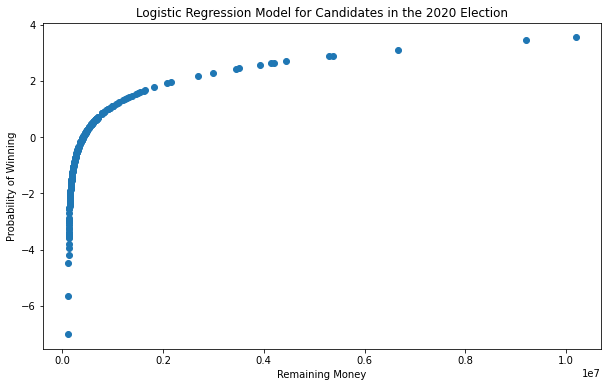

In [17]:
# Plot Logistic regression model 
fig, ax = plt.subplots(figsize=(10,6))
x = states_df['remaining_money']
y_logistic = np.log(log_reg_model.params[0] + (log_reg_model.params[1]*x))
plt.scatter(x, y_logistic)
plt.xlabel("Remaining Money")
plt.ylabel("Probability of Winning")
plt.title("Logistic Regression Model for Candidates in the 2020 Election");

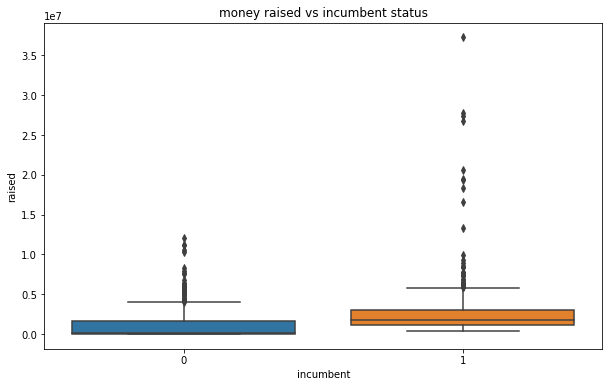

In [18]:
#build boxplot
plt.figure(figsize = (10,6))

sns.boxplot(data = states_df, x = 'incumbent', y = 'raised')
plt.title('money raised vs incumbent status');

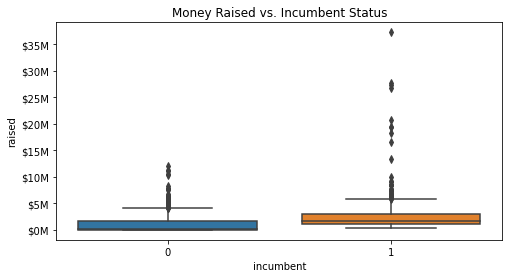

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
g = sns.boxplot(data = states_df,
                x = 'incumbent',
                y = 'raised'),
plt.ticklabel_format(style='plain', axis = 'y')
plt.title('Money Raised vs. Incumbent Status')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, 
                                                  pos: '${:,.0f}'.format(x/1000000) + 'M'));

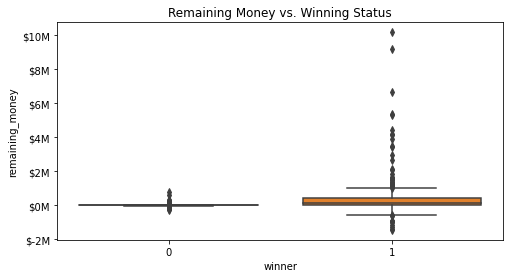

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
g = sns.boxplot(data = states_df,
                x = 'winner',
                y = 'remaining_money'),
plt.ticklabel_format(style='plain', axis = 'y')
plt.title('Remaining Money vs. Winning Status')
ax.yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, 
                                                  pos: '${:,.0f}'.format(x/1000000) + 'M'));

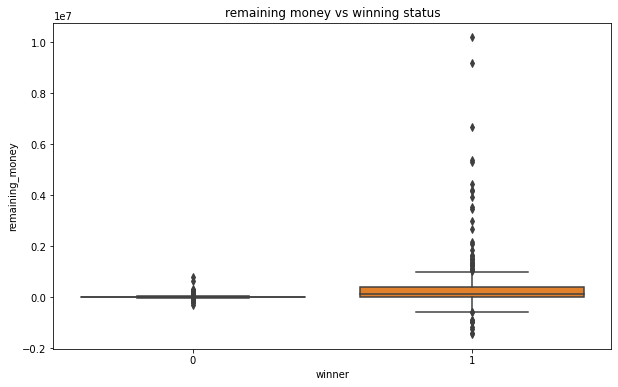

In [20]:
plt.figure(figsize = (10,6))

sns.boxplot(data = states_df, x = 'winner', y = 'remaining_money')
plt.title('remaining money vs winning status');

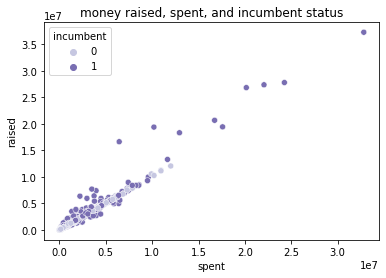

In [21]:
sns.scatterplot(x=states_df['spent'], y=states_df['raised'], hue=states_df['incumbent'], palette = 'Purples')
plt.title('money raised, spent, and incumbent status');

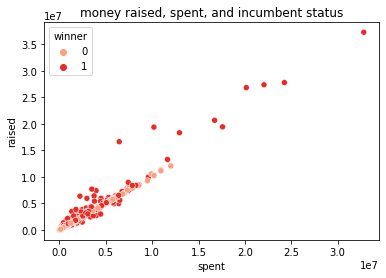

In [22]:
sns.scatterplot(x=states_df['spent'], y=states_df['raised'], hue=states_df['winner'], palette = 'Reds')
plt.title('money raised, spent, and incumbent status');

#### d. How often does the incumbent candidate win a race?

In [25]:
# Group dataset by Incumbent status and if if they won the race or not
incumbent_winners = states_df.groupby(['incumbent', 'winner']).size().unstack().iloc[::-1, ::-1]
incumbent_winners.iloc[0] = incumbent_winners.iloc[0]/incumbent_winners.iloc[0].sum()
incumbent_winners.iloc[1] = incumbent_winners.iloc[1]/incumbent_winners.iloc[1].sum()

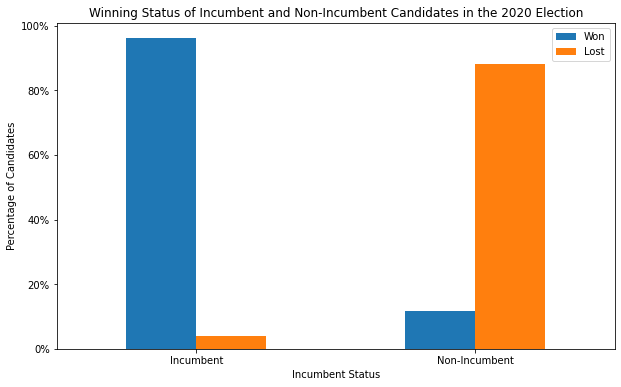

In [26]:
# Investigate how often the incumbent candidate wins a race
fig, ax = plt.subplots(figsize=(10,6))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1, decimals=None, symbol='%', is_latex=False))
incumbent_winners.plot(kind='bar',
                       rot=0,
                       ax=ax)
plt.title('Winning Status of Incumbent and Non-Incumbent Candidates in the 2020 Election')
plt.xlabel('Incumbent Status')
plt.ylabel('Percentage of Candidates')
plt.xticks([0,1], ['Incumbent', 'Non-Incumbent'])
plt.legend(['Won', 'Lost'], loc=1);


In [27]:
#total number of incumbents is 386 people
states_df ['incumbent'].value_counts()

0    508
1    386
Name: incumbent, dtype: int64

In [28]:
#86% of winners are incumbents
states_df.groupby('winner')['incumbent'].value_counts(normalize= True)

winner  incumbent
0       0            0.967603
        1            0.032397
1       1            0.860789
        0            0.139211
Name: incumbent, dtype: float64

#### e. Can you detect any relationship between amount of money raised and the incumbent status of a candidate?

In [29]:
incumbents= states_df.set_index ('incumbent').loc [1]

In [30]:
incumbents 

,candidate,raised,spent,cash_left,year,state,district,party,winner,remaining_money
incumbent,,,,,,,,,,
1,Mike D Rogers,1193111.0,1218564.0,502234.0,2020-12-31,AL,3,R,1,-25453.0
1,Robert B Aderholt,1255076.0,1323812.0,647004.0,2020-12-31,AL,4,R,1,-68736.0
1,Mo Brooks,655365.0,210045.0,1137501.0,2020-12-31,AL,5,R,1,445320.0
1,Gary Palmer,907219.0,909082.0,370688.0,2020-12-31,AL,6,R,1,-1863.0
1,Terri Sewell,2168165.0,1495957.0,2243480.0,2020-12-31,AL,7,D,1,672208.0
...,...,...,...,...,...,...,...,...,...,...
1,Gwen Moore,1183995.0,1166739.0,34000.0,2020-12-31,WI,4,D,1,17256.0
1,Glenn S Grothman,1815756.0,1736659.0,269431.0,2020-12-31,WI,6,R,1,79097.0
1,Tom Tiffany,2637459.0,2514740.0,122719.0,2020-12-31,WI,7,R,1,122719.0


In [31]:
states_df.groupby(['candidate','state', 'district']).max('raised').sort_values('raised', ascending= False)

,,,raised,spent,cash_left,incumbent,winner,remaining_money
candidate,state,district,,,,,,
Steve Scalise,LA,1,37262827.0,32830607.0,6217720.0,1,1,4432220.0
Kevin McCarthy,CA,23,27780644.0,24265583.0,4802133.0,1,1,3515061.0
Nancy Pelosi,CA,12,27359508.0,22064953.0,6299373.0,1,1,5294555.0
Devin Nunes,CA,22,26825212.0,20156093.0,10908033.0,1,1,6669119.0
Alexandria Ocasio,NY,14,20664795.0,16735422.0,4297383.0,1,1,3929373.0
...,...,...,...,...,...,...,...,...
Joshua Sauberman,NY,3,127.0,270.0,-2258.0,0,0,-143.0
Amit Lal,NY,5,126.0,0.0,126.0,0,0,126.0
Michael David Sanchez,TX,14,100.0,12.0,88.0,0,0,88.0
